In [2]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler

# fetch dataset
iris = fetch_ucirepo(id=53)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
X = iris.data.features
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = iris.data.targets

# load the dataloader
from torch.utils.data import DataLoader

In [3]:
y = y.copy()
y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

/tmp/ipython-input-2538754208.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})


In [4]:
# convert to a pytorch tensor
data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).float()
labels = labels.view(-1, 1)
labels=labels.squeeze().long()

# Break the data into batches

In [5]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# the model

In [6]:
# a function that creates the ANN model

def model(L2lambda):

    # model architecture
    ANN = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optim
    optim = torch.optim.SGD(ANN.parameters(),lr=.005,weight_decay=L2lambda)

    return ANN,lossfunc,optim

In [7]:
# train the model

# global parameter
epochs = 1000

def train():

    # initialize accuracies as empties
    train_accuracy = []
    test_accuracy  = []
    losses   = []

    # loop over epochs
    for i in range(epochs):

        # loop over training data batches
        batch_accuracy  = []
        batch_loss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = ANN(X)
            loss = lossfunc(yHat,y)

            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()

            # compute training accuracy just for this batch
            batch_accuracy.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
            batch_loss.append( loss.item() )
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        train_accuracy.append( np.mean(batch_accuracy) )
        losses.append( np.mean(batch_loss) )

        # test accuracy
        ANN.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        predlabels = torch.argmax( ANN(X),axis=1 )
        test_accuracy.append( 100*torch.mean((predlabels == y).float()).item() )

        # no worries, reset here ;)
        ANN.train()

    # function output
    return train_accuracy,test_accuracy,losses


In [8]:
# create a model
L2lambda = .01
ANN,lossfunc,optim = model(L2lambda)

# train the model
train_accuracy,test_accuracy,losses = train()


<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3603001338.py:8: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))
/tmp/ipython-input-3603001338.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))


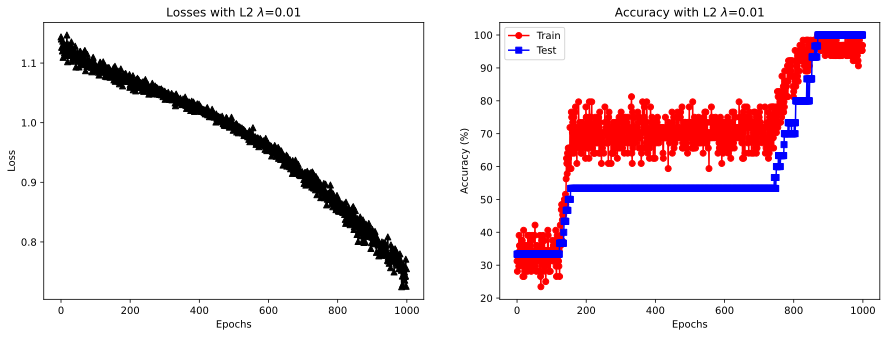

In [9]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(train_accuracy,'ro-')
ax[1].plot(test_accuracy,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [10]:
# create a 1D smoothing filter
def smooth(x,k):
    return np.convolve(x,np.ones(k)/k,mode='same')

# The experiment

In [11]:
# range of L2 regularization amounts
l2lambdas = np.linspace(0,.1,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(l2lambdas)))
accuracyResultsTest  = np.zeros((numepochs,len(l2lambdas)))


# loop over batch sizes
for li in range(len(l2lambdas)):

    # create and train a model
    ANN,lossfunc,optim = model(l2lambdas[li])
    train_accuracy,test_accuracy,losses = train()

    # store data
    accuracyResultsTrain[:,li] = smooth(train_accuracy,10)
    accuracyResultsTest[:,li]  = smooth(test_accuracy,10)

NameError: name 'numepochs' is not defined

In [ ]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in l2lambdas]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

In [ ]:
# show average accuracy by L2 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Experiments

1) In this experiment, we have shown that L2 regularization has a negative impact on small, or simple, architectures. Based on our previous discussion (see ppt) L2 regularization only benefits large and complex models. For this experiment, modify the model architecture to have more than two hidden layers and increase the number of epochs. Note: Set seed your experiment.

2) Experiment with combining L2 regularization and dropout.

/tmp/ipython-input-3612196264.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["class"] = y["class"].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})


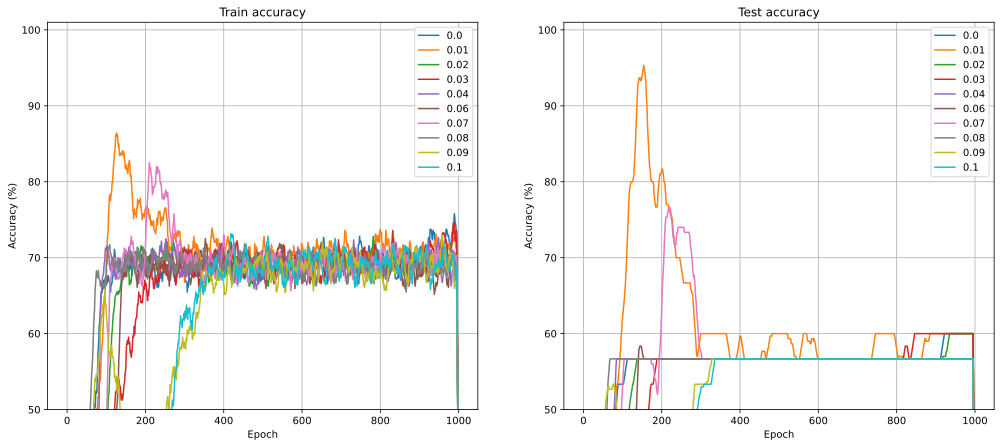

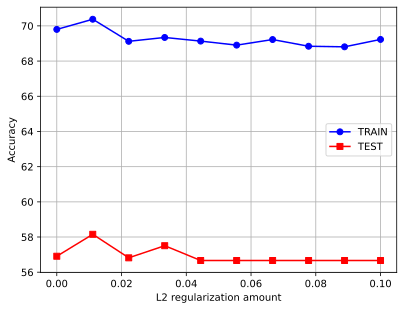

In [12]:
# Fixing the code

# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Set seed for reproducibility
seed = 619
np.random.seed(seed)
torch.manual_seed(seed)

# Load and preprocess Iris dataset
iris = fetch_ucirepo(id=53)
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(iris.data.features), columns=iris.data.features.columns)
y = iris.data.targets.copy()
y["class"] = y["class"].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).squeeze().long()

# Train-test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=seed)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_data))

# Model factory with L2 regularization
def model(L2lambda):
    ANN = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3),
    )
    lossfunc = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(ANN.parameters(), lr=0.005, weight_decay=L2lambda)
    return ANN, lossfunc, optim

# Training function
def train():
    train_accuracy = []
    test_accuracy = []
    losses = []

    for _ in range(epochs):
        batch_accuracy = []
        batch_loss = []

        for X, y in train_loader:
            yHat = ANN(X)
            loss = lossfunc(yHat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()

            batch_accuracy.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
            batch_loss.append(loss.item())

        train_accuracy.append(np.mean(batch_accuracy))
        losses.append(np.mean(batch_loss))

        ANN.eval()
        X, y = next(iter(test_loader))
        predlabels = torch.argmax(ANN(X), axis=1)
        test_accuracy.append(100 * torch.mean((predlabels == y).float()).item())
        ANN.train()

    return train_accuracy, test_accuracy, losses

# Smoothing function
def smooth(x, k):
    return np.convolve(x, np.ones(k)/k, mode='same')

# Global parameters
epochs = 1000
l2lambdas = np.linspace(0, 0.1, 10)

# Initialize results
accuracyResultsTrain = np.zeros((epochs, len(l2lambdas)))
accuracyResultsTest = np.zeros((epochs, len(l2lambdas)))

# Run experiments across L2 values
for li in range(len(l2lambdas)):
    ANN, lossfunc, optim = model(l2lambdas[li])
    train_accuracy, test_accuracy, losses = train()
    accuracyResultsTrain[:, li] = smooth(train_accuracy, 10)
    accuracyResultsTest[:, li] = smooth(test_accuracy, 10)

# Plot accuracy curves
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

leglabels = [np.round(i, 2) for i in l2lambdas]
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50, 101])
    ax[i].grid()
plt.show()

# Plot average accuracy over selected epochs
epoch_range = [500, 950]
plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1], :], axis=0),
         'bo-', label='TRAIN')
plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1], :], axis=0),
         'rs-', label='TEST')
plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

/tmp/ipython-input-1723190042.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["class"] = y["class"].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})


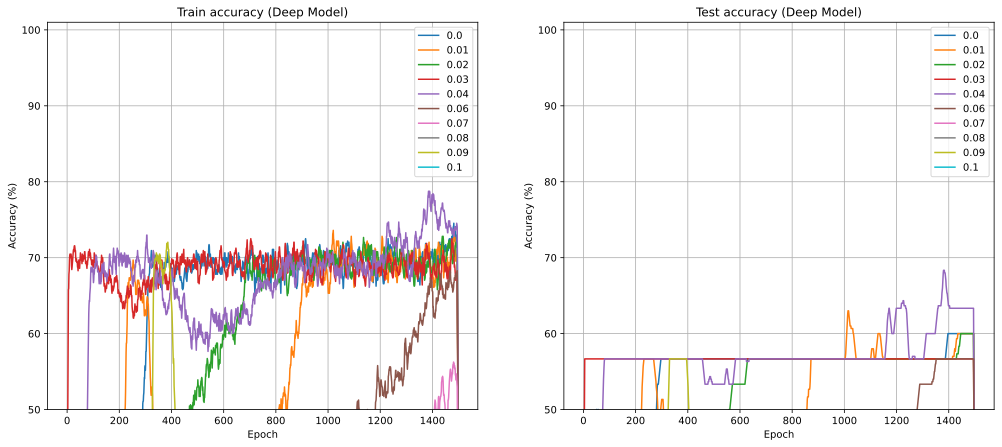

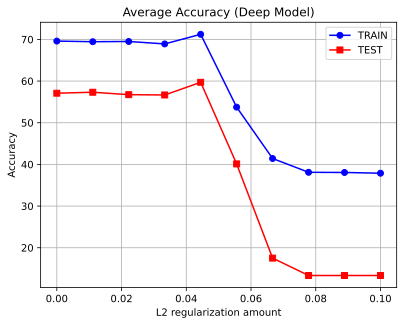

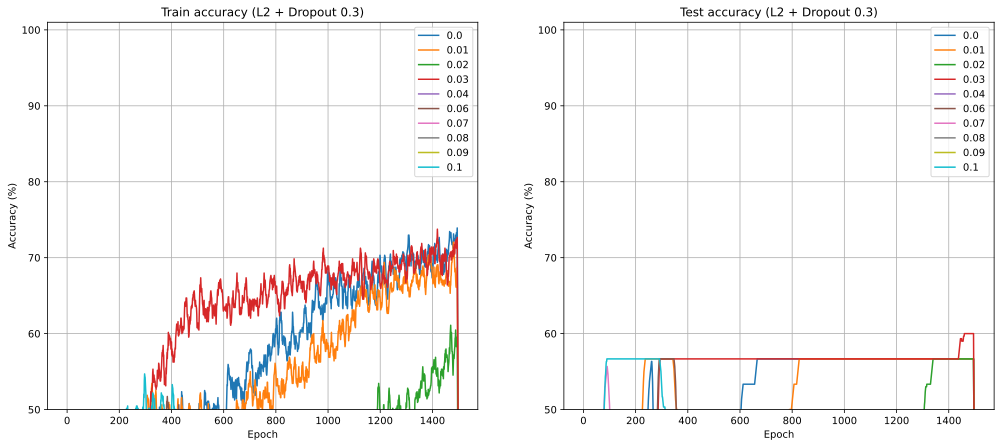

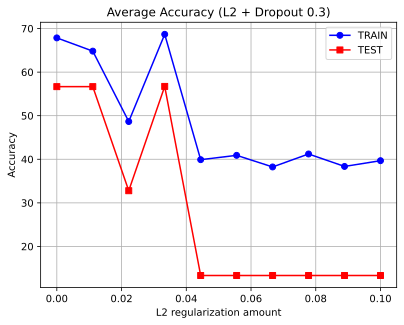

In [13]:
# Trying the Experiment

# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Set seed
seed = 619
np.random.seed(seed)
torch.manual_seed(seed)

# Load and preprocess Iris dataset
iris = fetch_ucirepo(id=53)
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(iris.data.features), columns=iris.data.features.columns)
y = iris.data.targets.copy()
y["class"] = y["class"].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).squeeze().long()

# Train-test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=seed)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_data))

# Model factory: Deep model with optional dropout
def model(L2lambda, dropoutRate=0.0):
    class DeepANN(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(4, 64)
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, 32)
            self.fc4 = nn.Linear(32, 3)
            self.dr = dropoutRate

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.fc2(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.fc3(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            return self.fc4(x)

    ANN = DeepANN()
    lossfunc = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(ANN.parameters(), lr=0.005, weight_decay=L2lambda)
    return ANN, lossfunc, optim

# Training function
def train():
    train_accuracy = []
    test_accuracy = []
    losses = []

    for _ in range(epochs):
        batch_accuracy = []
        batch_loss = []

        for X, y in train_loader:
            yHat = ANN(X)
            loss = lossfunc(yHat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()

            batch_accuracy.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
            batch_loss.append(loss.item())

        train_accuracy.append(np.mean(batch_accuracy))
        losses.append(np.mean(batch_loss))

        ANN.eval()
        X, y = next(iter(test_loader))
        predlabels = torch.argmax(ANN(X), axis=1)
        test_accuracy.append(100 * torch.mean((predlabels == y).float()).item())
        ANN.train()

    return train_accuracy, test_accuracy, losses

# Smoothing function
def smooth(x, k):
    return np.convolve(x, np.ones(k)/k, mode='same')

# Global parameters
epochs = 1500
l2lambdas = np.linspace(0, 0.1, 10)

# Initialize results
accuracyResultsTrain = np.zeros((epochs, len(l2lambdas)))
accuracyResultsTest = np.zeros((epochs, len(l2lambdas)))

# Run Experiment 1: Deep model with L2 only
for li in range(len(l2lambdas)):
    ANN, lossfunc, optim = model(L2lambda=l2lambdas[li], dropoutRate=0.0)
    train_accuracy, test_accuracy, losses = train()
    accuracyResultsTrain[:, li] = smooth(train_accuracy, 10)
    accuracyResultsTest[:, li] = smooth(test_accuracy, 10)

# Plot results for Experiment 1
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy (Deep Model)')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy (Deep Model)')

leglabels = [np.round(i, 2) for i in l2lambdas]
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50, 101])
    ax[i].grid()
plt.show()

# Plot average accuracy over selected epochs
epoch_range = [1000, 1450]
plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1], :], axis=0),
         'bo-', label='TRAIN')
plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1], :], axis=0),
         'rs-', label='TEST')
plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Average Accuracy (Deep Model)')
plt.show()

# Run Experiment 2: Deep model with L2 + Dropout
dropoutRate = 0.3
accuracyResultsTrain = np.zeros((epochs, len(l2lambdas)))
accuracyResultsTest = np.zeros((epochs, len(l2lambdas)))

for li in range(len(l2lambdas)):
    ANN, lossfunc, optim = model(L2lambda=l2lambdas[li], dropoutRate=dropoutRate)
    train_accuracy, test_accuracy, losses = train()
    accuracyResultsTrain[:, li] = smooth(train_accuracy, 10)
    accuracyResultsTest[:, li] = smooth(test_accuracy, 10)

# Plot results for Experiment 2
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
ax[0].plot(accuracyResultsTrain)
ax[0].set_title(f'Train accuracy (L2 + Dropout {dropoutRate})')
ax[1].plot(accuracyResultsTest)
ax[1].set_title(f'Test accuracy (L2 + Dropout {dropoutRate})')

for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50, 101])
    ax[i].grid()
plt.show()

# Plot average accuracy over selected epochs
plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1], :], axis=0),
         'bo-', label='TRAIN')
plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1], :], axis=0),
         'rs-', label='TEST')
plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title(f'Average Accuracy (L2 + Dropout {dropoutRate})')
plt.show()